In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits import mplot3d
import datetime as dt

sns.set_style("whitegrid")

c:\Users\rehan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\rehan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\rehan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df=pd.read_csv("data.csv",encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[(df["InvoiceDate"].dt.year!=2011)|(df["InvoiceDate"].dt.month!=12)]

# Cleaning the Data



                                        Deleting the rows with missing values

In [5]:
df[df.isin(["NaN","missing","?","??"]).any(axis=1)].shape[0]

56

# Deal with the description format
There are some inconsistencies in the data descriptions.

In [6]:
df["Description"].nunique()

4214

In [7]:
df["Description"].str.lower().str.strip().nunique()

4185

In [8]:
df["Description"] = df["Description"].str.lower().str.strip()


## Dealing with non items
Some descriptions are just fees and not items. We can delete them.

In [9]:
df = df[df["Description"].isin(["amazon fee", "samples", "postage", "packing charge","manual","discount","adjust bad debt","bank charges","cruk commission","next day carriage"]) == False]

# Delete null price and quantities

In [10]:
df = df[(df["UnitPrice"]!=0)&(df["Quantity"]!=0)]

# Deal with data inconsistencies 

In [11]:
df["Description"].nunique()

4018

In [12]:
df["StockCode"].nunique()

3924

In [13]:
df.groupby("StockCode")["Description"].nunique().sort_values(ascending = False)

StockCode
23236           4
23196           4
23131           3
23413           3
23370           3
               ..
22419           1
22420           1
22421           1
22422           1
gift_0001_50    1
Name: Description, Length: 3924, dtype: int64

It is the same product, but written in different ways. I will just keep the first description that appears.



In [14]:
for stack_code in df["StockCode"].unique():
    first_description = df[df["StockCode"]==stack_code]["Description"].unique()[0]
    df.loc[df["StockCode"]==stack_code, "Description"] = first_description

I will check if the description is always linked to one stock code.



In [15]:
df.groupby("Description")["StockCode"].nunique().sort_values(ascending = False)

Description
metal sign,cupcake single hook      6
set of 4 fairy cake placemats       4
columbian candle round              3
pink stitched wall clock            2
woven berries cushion cover         2
                                   ..
french style storage jar bonbons    1
french style storage jar cafe       1
french style storage jar jam        1
french toilet sign blue metal       1
zinc wire sweetheart letter tray    1
Name: StockCode, Length: 3791, dtype: int64

In [16]:
for description in df["Description"].unique():
    first_code = df[df["Description"]==description]["StockCode"].unique()[0]
    df.loc[df["Description"]==description, "StockCode"] = first_code

Checking for NaN values

In [17]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     124510
Country             0
dtype: int64

Dealing with Outliers

<AxesSubplot:ylabel='TotalPrice'>

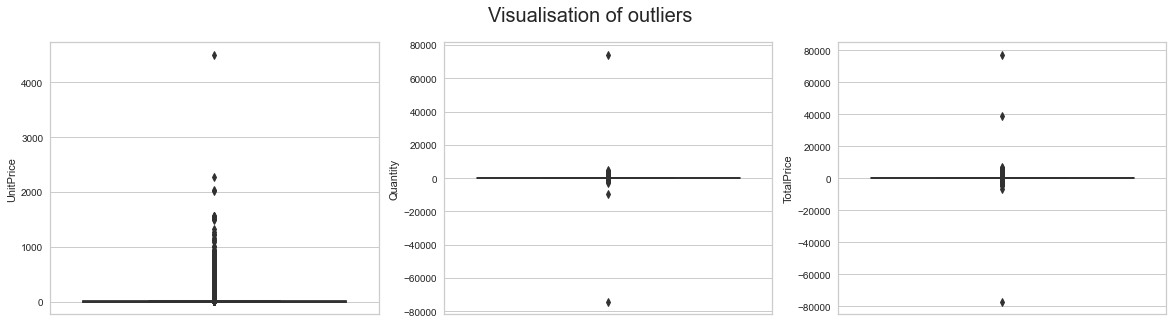

In [18]:
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]

fig = plt.figure(figsize = (20,5))
fig.suptitle("Visualisation of outliers",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.boxplot(data=df,y="UnitPrice")

axes = fig.add_subplot(1, 3, 2)
sns.boxplot(data=df,y="Quantity")

axes = fig.add_subplot(1, 3, 3)
sns.boxplot(data=df,y="TotalPrice")

In [19]:
df = df[(np.abs(stats.zscore(df[["TotalPrice"]])) < 3).all(axis=1)]

##                                                  Exploratory Data Analysis

What is the general sales trend?


To understand the general sales trend, I will plot the amount of money generated by the sales for each day through the studied period.

In [20]:
general_trend = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate).dt.date,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend = general_trend.groupby("Date")["Total price"].sum()
general_trend = pd.DataFrame(general_trend)

In [21]:
dates = []
dates.append(pd.to_datetime("201012",format="%Y%m"))
dates += [pd.to_datetime("2011"+str(month),format="%Y%m") for month in range(1,12)]

In [22]:
rolling_days = general_trend.copy()
rolling_days["Total price"] = rolling_days["Total price"].rolling(window=30).mean() 

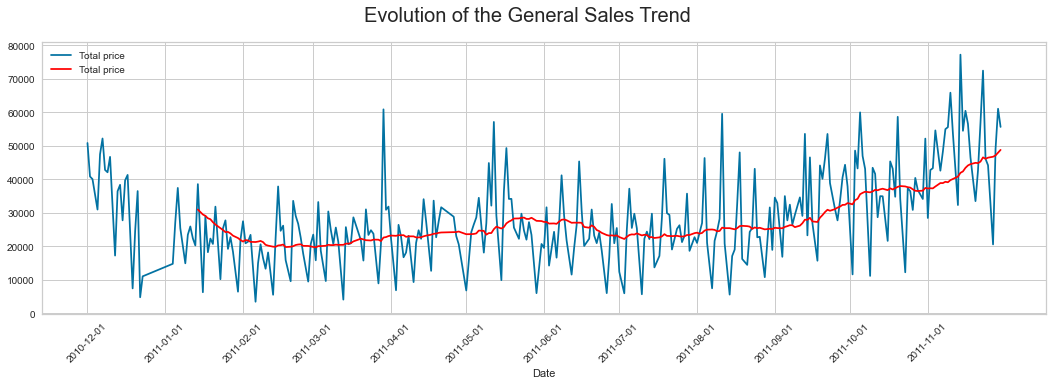

In [23]:
plt.figure(figsize = (18,5)).suptitle('Evolution of the General Sales Trend', fontsize=20)
sns.lineplot(data=general_trend)
sns.lineplot(data=rolling_days, palette=['red'])
plt.xticks(dates,rotation = 45)
plt.show()

In [24]:
general_trend.index = pd.to_datetime(general_trend.index)
general_trend_months = general_trend.groupby([general_trend.index.year,general_trend.index.month])['Total price'].sum()
general_trend_months = pd.DataFrame(general_trend_months)

In [25]:
general_trend_months

Total price
Date Date             
2010 12     678728.300
2011 1      530649.820
     2      482045.810
     3      643790.990
     4      475877.451
     5      694332.130
     6      620456.720
     7      621908.121
     8      654239.280
     9      902618.741
     10     965988.770
     11    1299220.630

In [26]:
general_trend_months["Date"] = dates

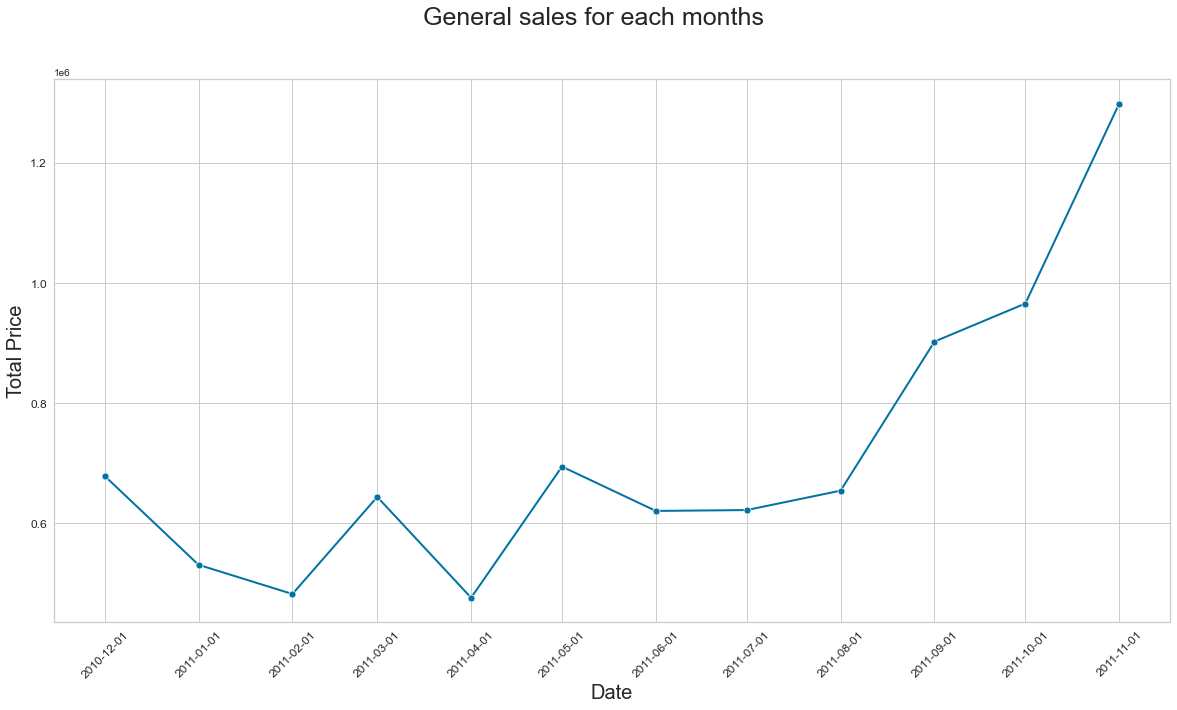

In [27]:
plt.figure(figsize = (20,10)).suptitle('General sales for each months', fontsize=25)
lineplot = sns.lineplot(data=general_trend_months,x="Date", y="Total price", marker="o",linewidth = 2)


lineplot.set_xlabel(xlabel="Date",size = 20)
lineplot.set_ylabel(ylabel="Total Price",size = 20)
plt.yticks(fontsize=12)
plt.xticks(dates,rotation = 45,fontsize=12)

plt.show()

# What is an average cart by country?


In this part I will study the trends per countries to spot any differencies. First of all try to see if there are difference in the way customers frome each country buy products in term of quantities and prices.

In [28]:
average_cart_countries = df.groupby("Country").TotalPrice.mean()
average_cart_countries = pd.DataFrame(average_cart_countries).reset_index()

average_price_countries = df.groupby("Country").UnitPrice.mean()
average_price_countries = pd.DataFrame(average_price_countries).reset_index()

average_quantity_countries = df.groupby("Country").Quantity.mean()
average_quantity_countries = pd.DataFrame(average_quantity_countries).reset_index()

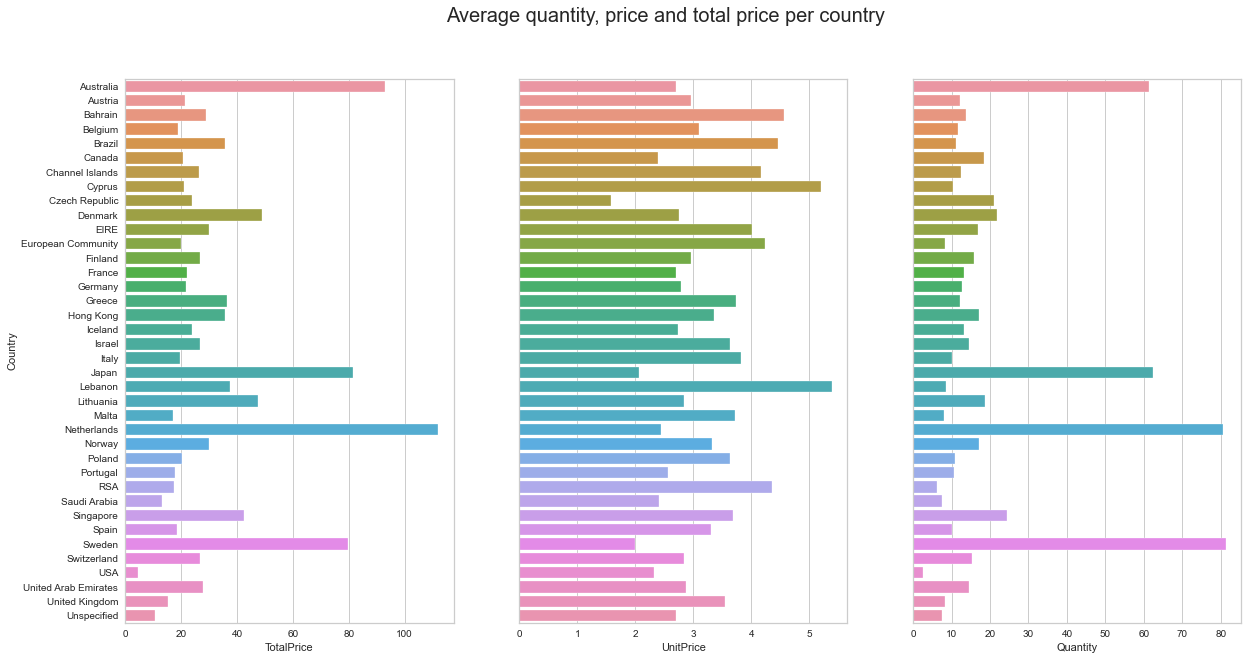

In [29]:
fig = plt.figure(figsize = (20,10))
fig.suptitle("Average quantity, price and total price per country",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=average_cart_countries,x="TotalPrice",y="Country")

axes = fig.add_subplot(1, 3, 2)
sns.barplot(data=average_price_countries,x="UnitPrice",y="Country")
fig.axes[1].get_yaxis().set_visible(False)

axes = fig.add_subplot(1, 3, 3)
sns.barplot(data=average_quantity_countries,x="Quantity",y="Country")
fig.axes[2].get_yaxis().set_visible(False)

In [30]:
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = average_cart_countries["Country"],
                  locationmode = "country names",
                  z = average_cart_countries["TotalPrice"].astype(float).round(0).tolist(),
                  hovertext = average_cart_countries["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Total Price", },
                ) 

layout = dict(
              title = "Average Total Price Per Cart By Country",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
iplot(fig)

### What are the best selling products?

We can also exhibit what items are the best for each countries.

In [37]:
sum_total_price_products = pd.DataFrame(df.groupby(["Country","Description"])["TotalPrice"].sum())
best_selling_product = pd.DataFrame(data=sum_total_price_products.groupby(["Country"])['TotalPrice'].idxmax().values.tolist(),columns =['Country', 'Best Selling Product'])

max_sales = sum_total_price_products.groupby("Country")["TotalPrice"].max().values.tolist()
best_selling_product["Sales"] = max_sales

total_sales = sum_total_price_products.groupby("Country")["TotalPrice"].sum().values.tolist() 
best_selling_product["Country total sales"] = total_sales

best_selling_product["% of country sales"] = best_selling_product["Sales"]/best_selling_product["Country total sales"]

In [38]:
best_selling_product


,Country,Best Selling Product,Sales,Country total sales,% of country sales
0,Australia,dolly girl lunch box,1689.60,114202.640,0.014795
1,Austria,pack of 6 pannetone gift boxes,302.40,8175.120,0.036990
2,Bahrain,ice cream sundae lip gloss,120.00,548.400,0.218818
3,Belgium,round snack boxes set of4 woodland,1181.40,35382.530,0.033389
4,Brazil,regency cakestand 3 tier,175.20,1143.600,0.153200
5,Canada,retro coffee mugs assorted,534.24,3115.440,0.171481
6,Channel Islands,regency cakestand 3 tier,517.80,19892.140,0.026030
7,Cyprus,rustic seventeen drawer sideboard,580.00,13022.540,0.044538
8,Czech Republic,round snack boxes set of4 woodland,70.80,671.720,0.105401
9,Denmark,red kitchen scales,734.40,17891.240,0.041048


In [39]:
df.Description.value_counts()[:10]

white hanging heart t-light holder    2284
regency cakestand 3 tier              2097
jumbo bag red retrospot               2089
party bunting                         1671
lunch bag red retrospot               1595
assorted colour bird ornament         1451
set of 3 cake tins pantry design      1421
small popcorn holder                  1396
pack of 72 retrospot cake cases       1347
lunch bag suki  design                1314
Name: Description, dtype: int64


How often do customers buy products?


In this part, I will study how often customers from the different countries buy items on the website.

In [40]:
count_transactions_per_country = df.groupby([df.Country,df.InvoiceDate]).Description.count().reset_index()
count_transactions_per_country = count_transactions_per_country.groupby([count_transactions_per_country.Country]).Description.sum()
count_transactions_per_country = pd.DataFrame(count_transactions_per_country)

In [41]:
unique_per_country = df.groupby([df.Country]).CustomerID.nunique()
unique_per_country = pd.DataFrame(unique_per_country)
unique_per_country = unique_per_country.drop("Hong Kong")

In [42]:
transactions_per_customer_per_countries = pd.concat([count_transactions_per_country,unique_per_country],axis=1).reset_index()
transactions_per_customer_per_countries["Value"] = transactions_per_customer_per_countries["Description"]/transactions_per_customer_per_countries["CustomerID"]/12

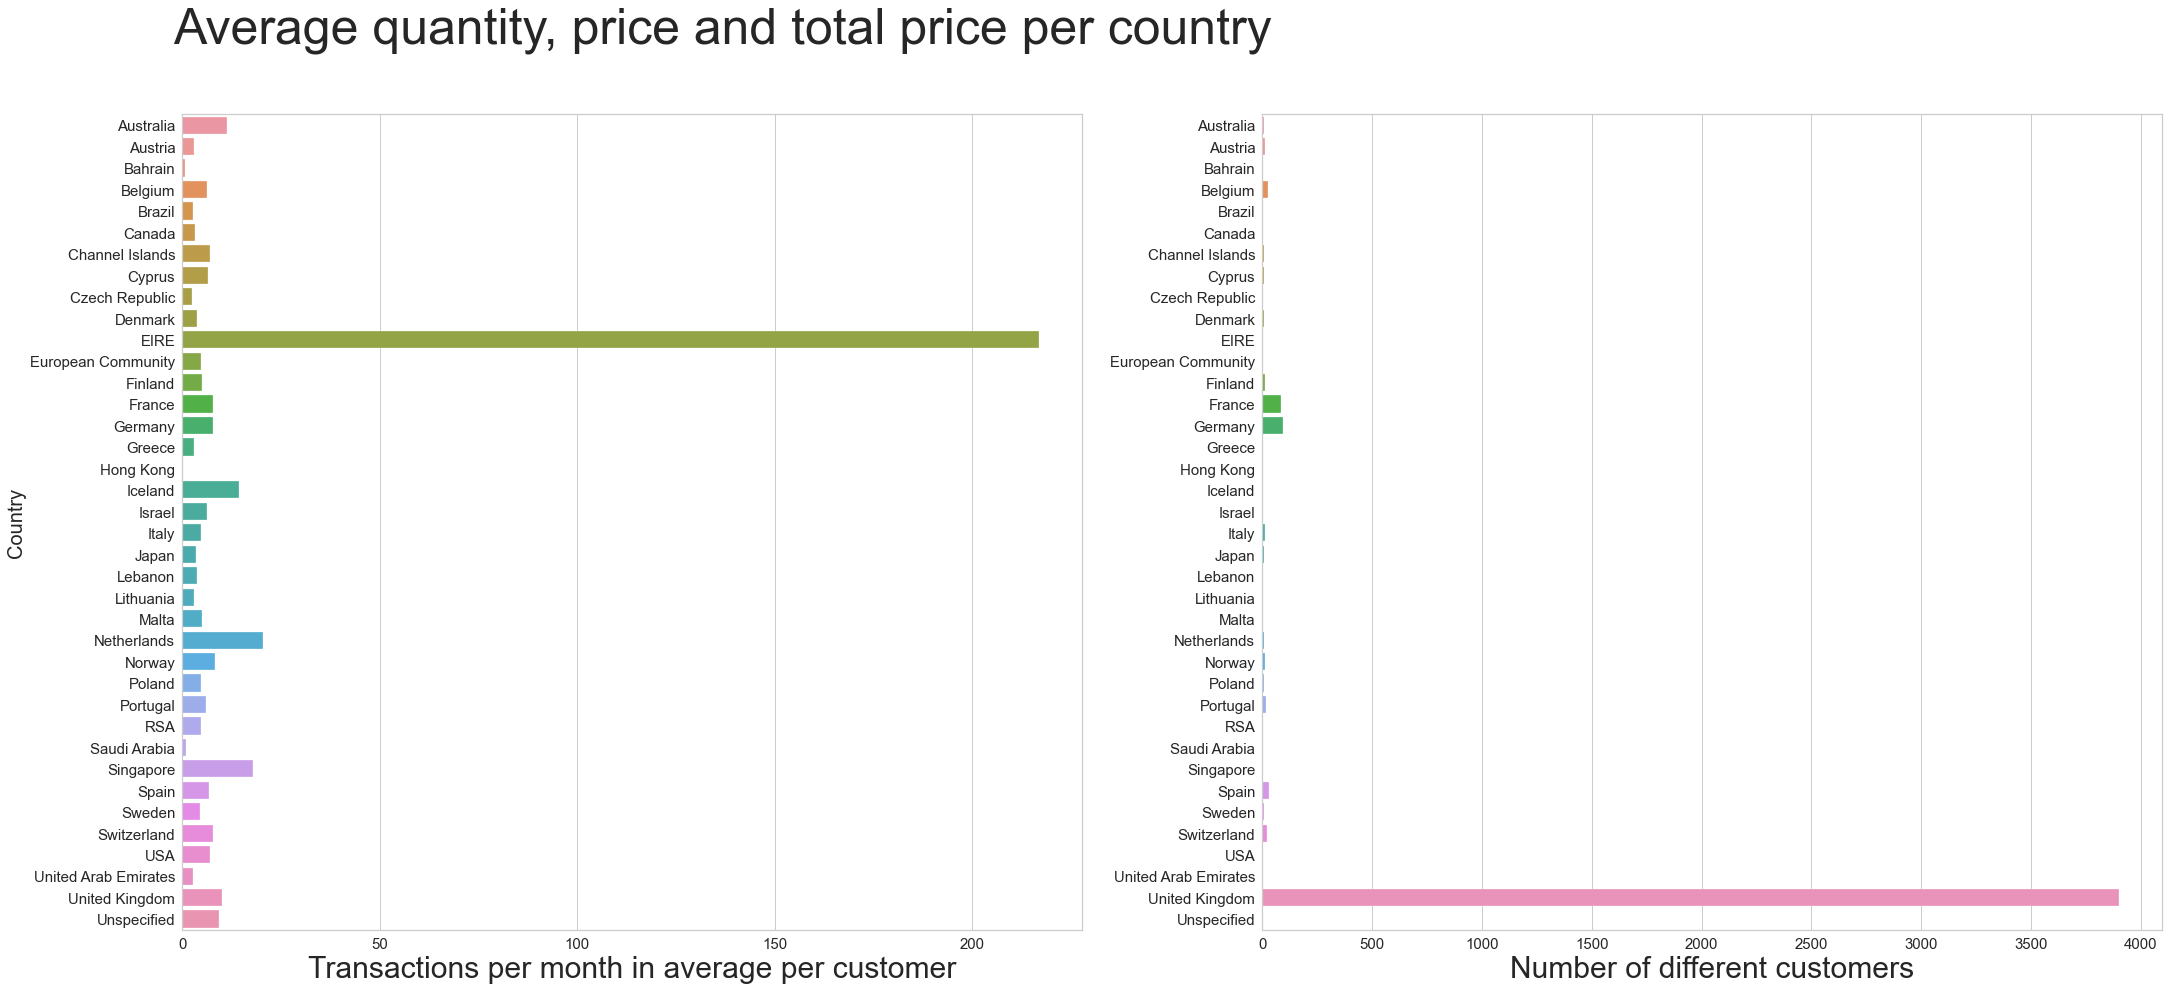

In [43]:
fig = plt.figure(figsize = (20,15))
fig.suptitle("Average quantity, price and total price per country",size=50)

axes = fig.add_subplot(1, 2, 1)
sns.barplot(data=transactions_per_customer_per_countries,x="Value",y="Country")
axes.set_xlabel('Transactions per month in average per customer',size = 30)
axes.set_ylabel('Country',size = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

axes = fig.add_subplot(1, 2, 2)
sns.barplot(data=transactions_per_customer_per_countries,x="CustomerID",y="Country")
axes.set_xlabel('Number of different customers',size = 30)
axes.set_ylabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.subplots_adjust(right=1.5)

plt.show()

What countries are the most active?

In [44]:
general_trend_country = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate),
                                   'Country':df.Country,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend_country = general_trend_country.groupby([general_trend_country.Date.dt.to_period("M"),general_trend_country.Country]).sum()
general_trend_country = pd.DataFrame(general_trend_country).reset_index()

In [45]:
general_trend_country.groupby([general_trend_country.Country]).sum().sort_values(by='Total price',ascending=False).head(10)

,Total price
Country,
United Kingdom,7207219.683
Netherlands,247908.660
EIRE,233058.520
Germany,191850.500
France,173482.940
Australia,114202.640
Switzerland,52505.350
Spain,43950.970
Belgium,35382.530


In [46]:
general_trend_country.Date = general_trend_country.Date.dt.to_timestamp()

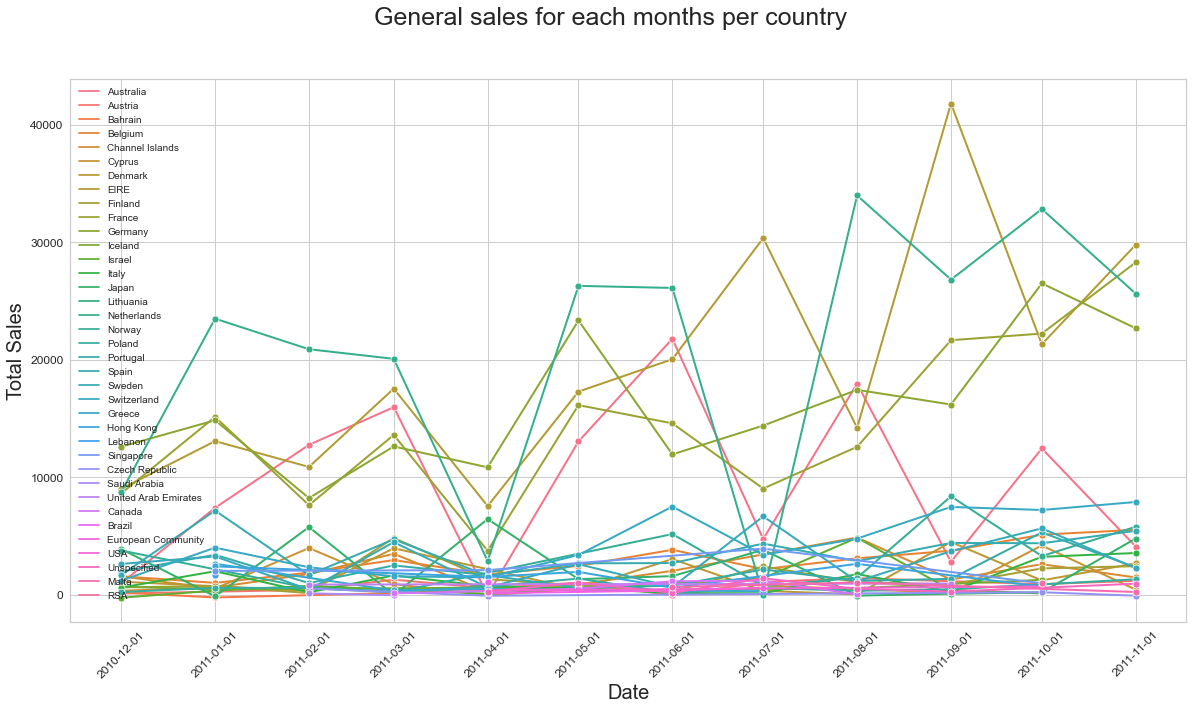

In [47]:
plt.figure(figsize = (20,10)).suptitle('General sales for each months per country', fontsize=25)
lineplot = sns.lineplot(data=general_trend_country.loc[general_trend_country.Country!="United Kingdom"],x="Date", y="Total price",hue="Country", marker="o",linewidth = 2)

x_dates = pd.to_datetime(dates).strftime('%Y-%m').sort_values().unique()

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Total Sales",fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(x_dates,rotation = 45,fontsize=12)
plt.legend(loc='upper left')

plt.show()

How many new customers each months?

In [48]:
number_customers = df.groupby(df["InvoiceDate"].dt.to_period('M'))["CustomerID"].nunique()
number_customers = pd.DataFrame(data=number_customers).reset_index()
number_customers["Date"] = number_customers.InvoiceDate.dt.to_timestamp()

number_new_customers = []
customers_seen = []
for month in df["InvoiceDate"].dt.to_period('M').unique():
    customers = df[df["InvoiceDate"].dt.to_period('M') == month].CustomerID.unique()
    count=0
    for customer in customers:
        if customer not in customers_seen:
            count+=1
            customers_seen.append(customer)
    number_new_customers.append((month,count))
number_new_customers = pd.DataFrame(number_new_customers,columns=["Date","New customers"])
number_new_customers.Date = number_new_customers.Date.dt.to_timestamp()

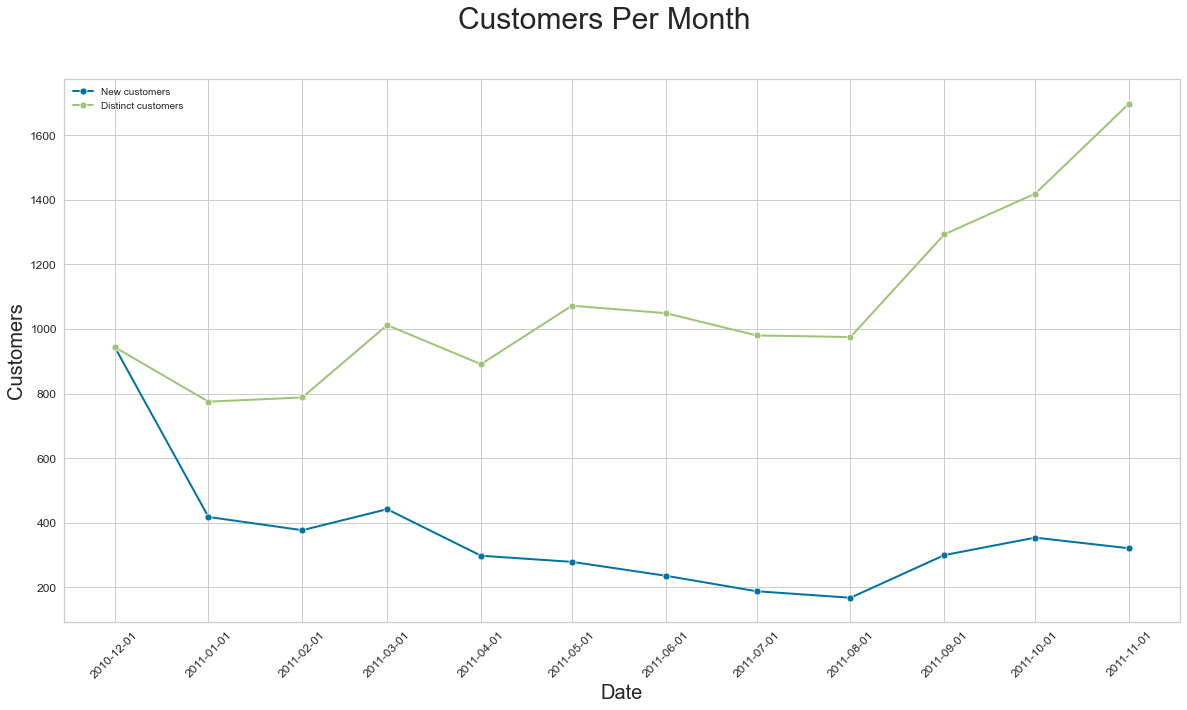

In [49]:
fig  = plt.figure(figsize = (20,10)).suptitle('Customers Per Month', fontsize=30)
lineplot = sns.lineplot(data=number_new_customers,x="Date", y="New customers", marker="o",linewidth = 2, label="New customers")
sns.lineplot(data=number_customers,x="Date", y="CustomerID", marker="o",linewidth = 2, label="Distinct customers")

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Customers",fontsize=20)
plt.xticks(dates,rotation = 45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

When do customers tend to purchase products?


In this part, I will try to understand if customers tend to purchase items in more particular time of the day.

In [50]:
df_temp = df.groupby([df.CustomerID,df.InvoiceDate]).Quantity.sum()
df_temp = pd.DataFrame(df_temp).reset_index()

In [51]:
df_temp["Hour"]= df_temp["InvoiceDate"].dt.hour
df_temp["Month"]= df_temp["InvoiceDate"].dt.to_period('M')

In [52]:
count_hours = pd.DataFrame(columns=range(1,25))
count_hours["Month"] = ""

for month in sorted(df_temp["Month"].unique()):
    row = []
    for hour in range(1,25):
        freq = len(df_temp[(df_temp["Month"]==month)&(df_temp["Hour"]==hour)])
        row.append(float(freq))
    row.append(month)
    count_hours.loc[len(count_hours)] = row
         
count_hours = count_hours.set_index("Month")  

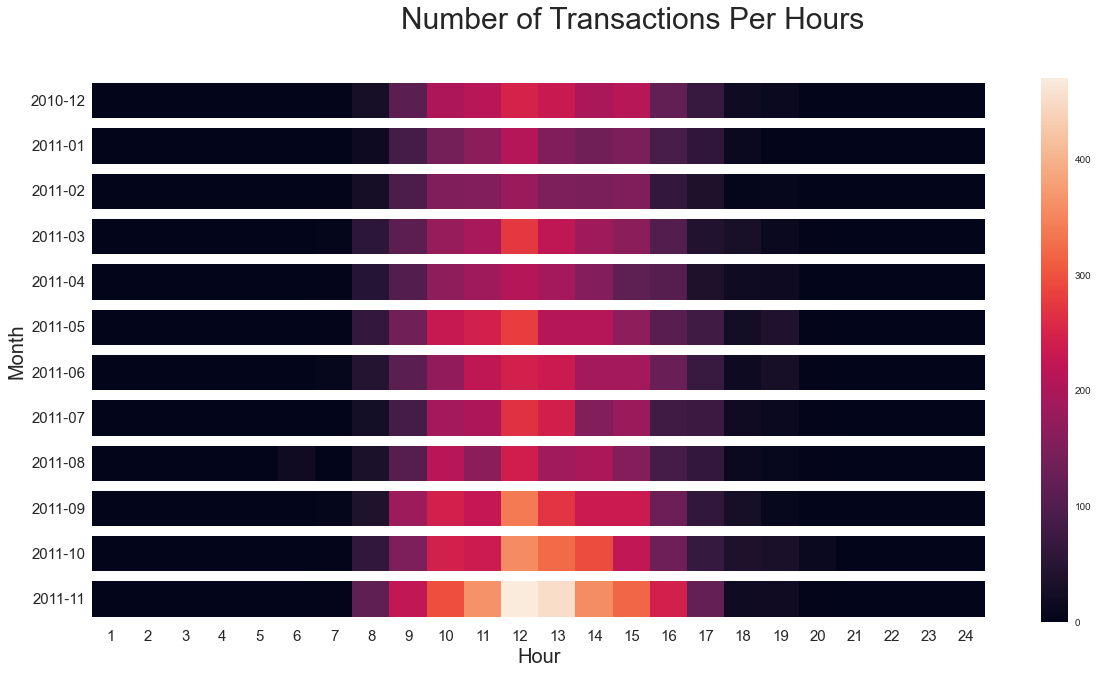

In [53]:
fig  = plt.figure(figsize = (20,10)).suptitle('Number of Transactions Per Hours', fontsize=30)
heatmap = sns.heatmap(data=count_hours)
plt.yticks(rotation=0,size=15)
plt.xticks(size=15)
heatmap.set_xlabel("Hour",fontsize=20)
heatmap.set_ylabel("Month",fontsize=20)
for i in range(count_hours.shape[1] + 1):
    plt.axhline(i, color='white', lw=10)

plt.show()

In [54]:
def daytime_encoder(date):
    if (date.hour >= 5)&(date.hour < 8):
        return "Early morning"
    elif (date.hour >= 8)&(date.hour < 11):
        return "Morning"
    elif (date.hour >= 11)&(date.hour < 13):
        return "Late morning"
    elif (date.hour >= 13)&(date.hour < 14):
        return "Early afternoon"
    elif (date.hour >= 14)&(date.hour < 15):
        return "Afternoon"
    elif (date.hour >= 15)&(date.hour < 17):
        return "Late afternoon"
    elif (date.hour >= 17)&(date.hour < 21):
        return "Evening"
    else:
        return date.hour

df_temp['InvoiceDate'] = df_temp['InvoiceDate'].map(daytime_encoder)

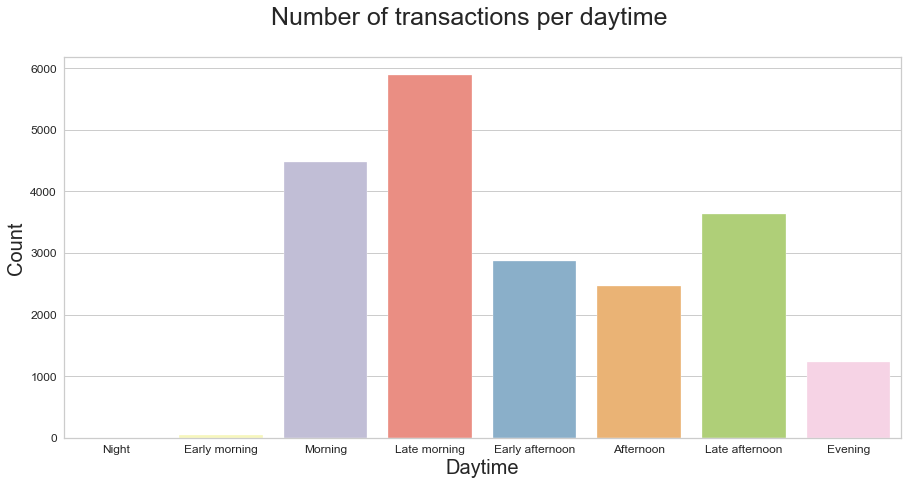

In [55]:
fig  = plt.figure(figsize = (15,7)).suptitle('Number of transactions per daytime', fontsize=25)
countplot = sns.countplot(data=df_temp,x="InvoiceDate",order = ["Night","Early morning","Morning","Late morning","Early afternoon","Afternoon","Late afternoon","Evening"], palette="Set3")

countplot.set_xlabel("Daytime",fontsize=20)
countplot.set_ylabel("Count",fontsize=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

##  Segmentation of the customers

In [56]:
today_date = dt.datetime(2011, 12, 1)

In [57]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo'    : lambda InvoiceNo: InvoiceNo.nunique(),
                                     'TotalPrice' : lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']

In [58]:
#more days since last purchase 1 (very bad) ; those with fewer days 5 (very good).
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

#5 (very good) for those with high purchasing frequency; the ones that were less as 1 (very bad).
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#5 (very good) for those with a high purchase price;  the fewer purchase price as 1 (very bad).
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

#we'll not include monetory_score.
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [59]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12347.0,30,6,4085.18,4,4,5,44,loyal_customers
1,12348.0,66,4,1437.24,3,4,4,34,loyal_customers
2,12349.0,9,1,1457.55,5,1,4,51,new_customers
3,12350.0,301,1,294.40,1,1,2,11,hibernating
4,12352.0,27,8,1265.41,4,5,4,45,loyal_customers


In [60]:
segments_count = rfm.groupby("segment").agg({"CustomerID": "count"})
segments_count.reset_index(inplace=True)
segments_count.columns = ['segment', 'count']
segments_count.head(15)

,segment,count
0,about_to_sleep,361
1,at_Risk,612
2,cant_loose,80
3,champions,634
4,hibernating,1018
5,loyal_customers,797
6,need_attention,177
7,new_customers,66
8,potential_loyalists,474
9,promising,95


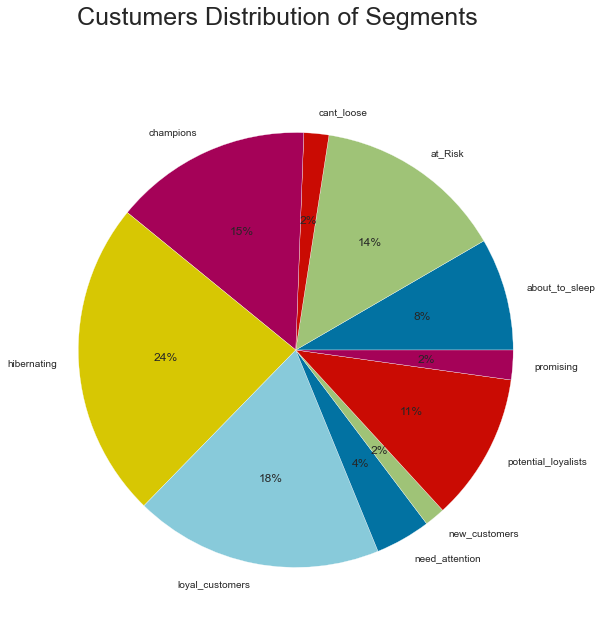

In [61]:
fig  = plt.figure(figsize = (20,10)).suptitle('Custumers Distribution of Segments', fontsize=25)
plt.pie(segments_count["count"], labels = segments_count["segment"], autopct='%.0f%%')

plt.show()

In [62]:
agg_list=["mean", "count", "max"]
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(agg_list)

recency             frequency                monetary  \
                           mean count  max       mean count  max         mean   
segment                                                                         
about_to_sleep        49.229917   361   68   1.243767   361    2   424.363521   
at_Risk              158.434641   612  363   3.155229   612    6   812.612583   
cant_loose           130.025000    80  303   8.962500    80   35  2227.118000   
champions              5.052050   634   12  13.246057   634  232  5048.993770   
hibernating          215.314342  1018  364   1.169941  1018    2   373.458684   
loyal_customers       31.190715   797   68   8.065245   797   65  2862.478471   
need_attention        47.977401   177   68   2.570621   177    3   784.676045   
new_customers          6.121212    66   12   1.000000    66    1   301.440758   
potential_loyalists   14.208861   474   30   2.099156   474    3   617.368903   
promising             20.747368    95   30   1.000000    95    1   357.926105   

                                      
                    count        max  
segment                               
about_to_sleep        361    4279.71  
at_Risk               612    6336.00  
cant_loose             80   11056.93  
champions             634  243207.14  
hibernating          1018    9338.38  
loyal_customers       797  101452.26  
need_attention        177    3683.86  
new_customers          66    1457.55  
potential_loyalists   474    3280.75  
promising              95    6207.67

## Clustering of the customers

In [63]:
df_clustering = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo'    : 'nunique',
                                     'TotalPrice' : 'sum'})

df_clustering.columns = ['recency', 'frequency', 'monetary']

In [64]:
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled,columns=['recency', 'frequency', 'monetary'])
df_scaled["CustomerID"] = df_clustering.index
df_scaled = df_scaled.set_index("CustomerID",drop=True)

To determine the number of clusters, I will use the elbow method.

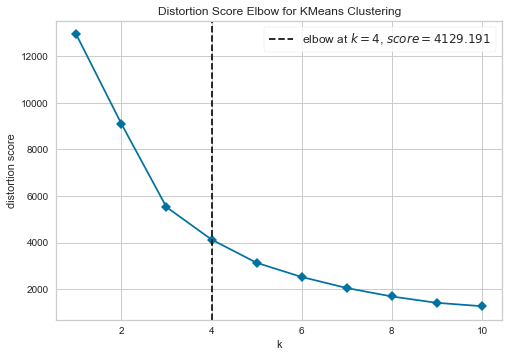

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_scaled)        
visualizer.show()      

In [66]:
kmeans = KMeans(n_clusters=4, n_init = 15, random_state=1)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df

,recency,frequency,monetary
0,-0.505254,-0.077718,-0.072624
1,1.510358,-0.346979,-0.209627
2,-0.861259,11.163562,14.164879
3,-0.781703,2.367451,1.406011


In [67]:
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

In [68]:
df_kmeans = df_clustering.copy()
df_kmeans['labels'] = df_labels['labels'].values

No handles with labels found to put in legend.


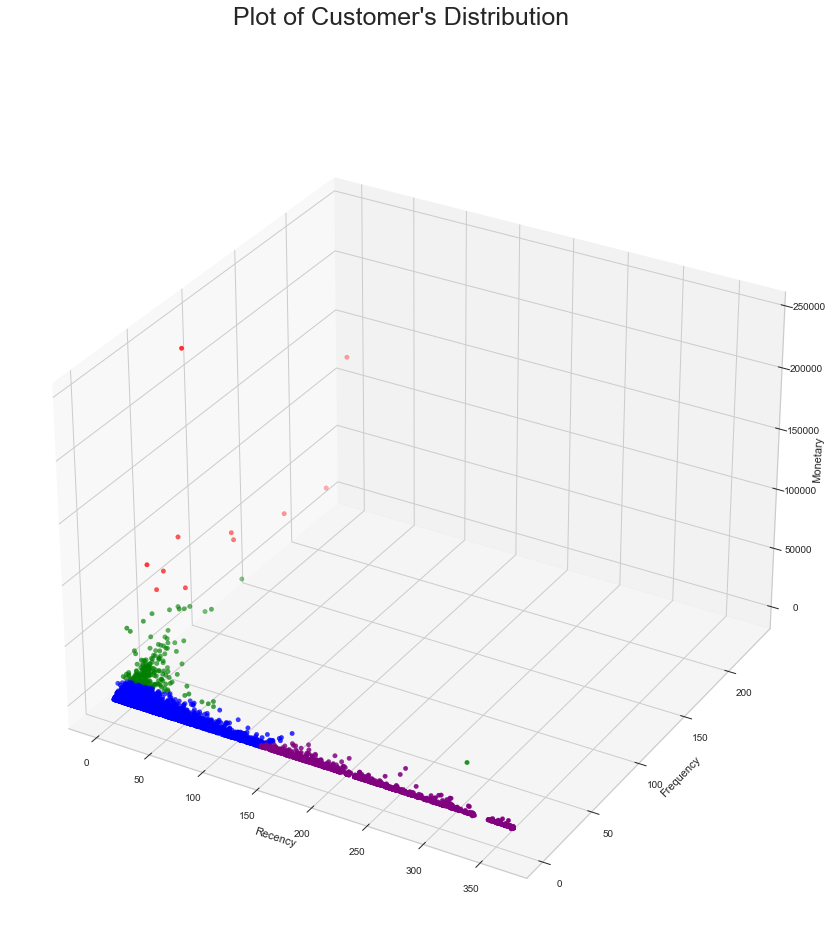

In [69]:
colors = np.array(["blue", "purple","red","green"])
fig  = plt.figure(figsize = (15,15)).suptitle('Plot of Customer\'s Distribution', fontsize=25)
ax = plt.axes(projection='3d')
ax.scatter3D(df_kmeans["recency"], df_kmeans["frequency"], df_kmeans["monetary"], marker='o', c=colors[df_kmeans["labels"].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

In [70]:
agg_list=["mean", "count", "max",]
df_kmeans[["labels", "recency", "frequency", "monetary"]].groupby("labels").agg(agg_list)

recency              frequency                 monetary        \
              mean count  max        mean count  max          mean count   
labels                                                                     
0        40.140845  2982  154    4.128102  2982   17   1234.838971  2982   
1       240.643885  1112  364    1.785971  1112   13    426.001314  1112   
2         4.727273    11   16  101.909091    11  232  85289.753636    11   
3        12.641148   209  293   25.397129   209  123   9964.353732   209   

                   
              max  
labels             
0        11056.93  
1         9338.38  
2       243207.14  
3        50415.49

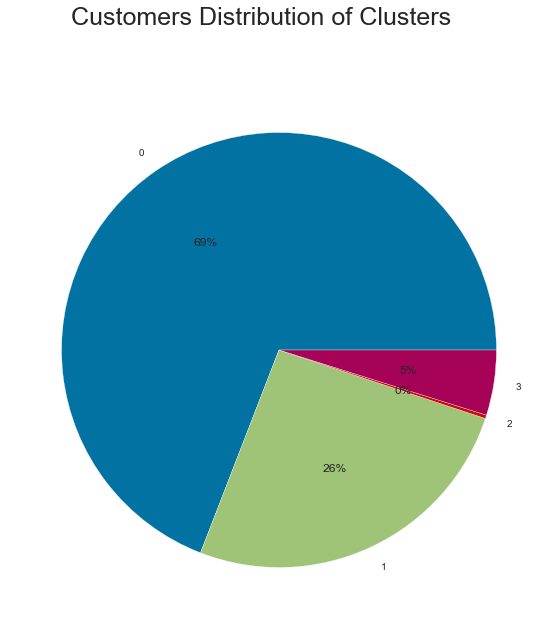

In [71]:
df_kmeans = df_kmeans.reset_index()
clusters_count = df_kmeans.groupby("labels").agg({"CustomerID": "count"})
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']

fig  = plt.figure(figsize = (20,10)).suptitle('Customers Distribution of Clusters', fontsize=25)
plt.pie(clusters_count["count"], labels = clusters_count["cluster"], autopct='%.0f%%')

plt.show()

From the KMeans clustering, we can sort every customer into 4 different clusters that seems to have different behaviours.

Cluster 0: "Punctual customers" - Those are the customers that buys more punctually items on the website.

Cluster 1: "Hibernating customers" - Those are the customers that buys at the lowest frequency, the lowest recently and that spend the least money.

Cluster 2: "Exceptional customers" - Those are the customers that we want to keep, that buys at the highest frequency, the most recently and that spend the most money.

Cluster 3: " Recent customers" - Those are customers that have been active quite recently that might be interesting to keep stimulated.

The total distorsion score obtained is 4129 using the recency, the frequency and the monetary.